## Zadania na dole notebooka

# MOwNiT 
## Laboratorium 1 - Arytmetyka komputerowa

Kalkulatory IEEE-754:
* http://babbage.cs.qc.cuny.edu/IEEE-754/
* https://www.h-schmidt.net/FloatConverter/IEEE754.html

In [1]:
# znak, cecha, mantysa
# uwaga - w Julii tablice indeksujemy od 1
# uwaga: ukryta jedynka nie jest pamiętana
# uwaga: cecha jest pamiętana w ko"dzie z nadmiarem (tutaj BIAS=127)
decode(x::Float32) = (b=bitstring(x); (b[1], b[2:9], b[10:32]))

decode (generic function with 1 method)

## Trochę teorii IEEE-754

Liczby zmienno przecinkowe są zapisywane w standardzie jako:

$L = (-1)^{znak} * mantysa * 2^{cecha}$ 

* znak - 0 oznacza liczbę dodatnią, 1 ujemną
* mantysa - wpływa na precyzje
* cecha - wpływa na zakres, składająca się z samych 0 albo 1 ma specjalne znaczenie

| Nazwa     | Liczba bitów | Bity znaku | Bity cechy | Bity mantysy | Bias  | Dokładność (cyfry znaczące) | Uwagi                                 |
|-----------|--------------|------------|------------|--------------|-------|-----------------------------|---------------------------------------|
| half      | 16           | 1          | 5          | 10           | 15    | 4                           |                                       |
| single    | 32           | 1          | 8          | 23           | 127   | 7                           |                                       |
| double    | 64           | 1          | 11         | 52           | 1023  | 16                          |                                       |
| quadruple | 128          | 1          | 15         | 112          | 16383 | 34                          | Wprowadzone w 2008, niezbyt popularne |

### Liczby znormalizowane

Mantysa ma wartość z przedziału [1,2) - zawsze pierwszy bit ma wartość 1, więc nie trzeba go zapisywać (jest on tam "domyślnie")
$L = (-1)^{znak} * 1.mantysa * 2^{cecha-bias}$

In [2]:
decode(Float32(2.5))

('0', "10000000", "01000000000000000000000")

In [3]:
cecha = 2^7-127
mantysa = 2^-2 + 1
cecha, mantysa

(1, 1.25)

In [4]:
L = 1 * mantysa * 2^cecha

2.5

### Liczba 0

Jeżeli zarówno mantysa jak i cecha zawierają same 0, to liczba reprezentuje wartość 0.

Ze względu na bit znaku, istnieją dwie reprezentacje 0: +0 oraz -0.

In [5]:
decode(Float32(-0.0))

('1', "00000000", "00000000000000000000000")

In [6]:
decode(Float32(+0.0))

('0', "00000000", "00000000000000000000000")

In [7]:
Float32(-0.0) == Float32(0.0)

true

### Liczby zdenormalizowane

Jeżeli cecha składa się z samych 0 to liczba jest *zdenormalizowana* i mantysa nie ma "domyślnego" bitu. Pozwala to na reprezentacje liczb bliskich 0, które bez denormalizacji byłyby 0.

$L = (-1)^{znak} * 0.mantysa * 2^{-bias+1}$

Uwaga: 0 nie jest zdenormalizowane, pomimo, że jego cecha ma same 0!

In [8]:
L = Float32(1e-42)
decode(Float32(L)), issubnormal(L)

(('0', "00000000", "00000000000001011001010"), true)

### Wartości specjalne

####  Nieskończoność

Reprezentowana jest przez cechę z 1 i mantysę z 0. W zależności od znaku można wyróżnić $-\infty$ oraz $+\infty$.

In [9]:
decode(Inf32)

('0', "11111111", "00000000000000000000000")

In [10]:
decode(-Inf32)

('1', "11111111", "00000000000000000000000")

#### NaN

Reprezentowana jest przez cechę z 1 i mantysę różną od 0. W zależności od znaku można wyróżnić $-\infty$ oraz $+\infty$.

NaNami są np 0/0, $\infty - \infty$

In [11]:
Float32(0)/Float32(0)

NaN32

In [12]:
Inf32 - Inf32

NaN32

In [13]:
decode(NaN32)

('0', "11111111", "10000000000000000000000")

### Praktyczne wskazówki

Kolejność działań ma znaczenie:

In [14]:
e = eps(Float32)/2

5.9604645f-8

In [15]:
(Float32(1.0) + e) + e 

1.0f0

In [16]:
Float32(1.0) + (e + e)

1.0000001f0

Sumujemy od najmniejszych

Nie powinno się porównywać floatów bezpośrednio. Większość języków posiada funkcje do porówywania liczb zmiennoprzecinkowych z tolerancją, np. `isapprox` w Julii, `numpy.isclose` w Pythonie.

In [17]:
0.1 + 0.2 == 0.3 

false

In [18]:
isapprox(0.1 + 0.2, 0.3)

true

## Przykłady

In [19]:
bitstring(Float32(.1))

"00111101110011001100110011001101"

In [20]:
bitstring(Float32(1.0))

"00111111100000000000000000000000"

In [21]:
bitstring(Float64(1.0))

"0011111111110000000000000000000000000000000000000000000000000000"

In [22]:
# domyślnie Float64
bitstring(1.0)

"0011111111110000000000000000000000000000000000000000000000000000"

In [23]:
# Float16
bitstring(Float16(1.0))

"0011110000000000"

In [24]:
println(significand(Float32(1.2)), "*2^", exponent(Float32(1.20)))

1.2*2^0


In [25]:
# co ile liczby sa reprezentowane 
c=Float32[]
a=Float32(1.0)
r=1:10
for i=r
    push!(c, a)
    a=nextfloat(a)
end
map(x-> bitstring(x),c)

10-element Array{String,1}:
 "00111111100000000000000000000000"
 "00111111100000000000000000000001"
 "00111111100000000000000000000010"
 "00111111100000000000000000000011"
 "00111111100000000000000000000100"
 "00111111100000000000000000000101"
 "00111111100000000000000000000110"
 "00111111100000000000000000000111"
 "00111111100000000000000000001000"
 "00111111100000000000000000001001"

In [32]:
# Maszynowe epsilon mówi, jaki jest odstęp między kolejnymi liczbami zmiennoprzecinkowymi reprezentowanymi w komputerze
eps(Float32(1))

1.1920929f-7

In [27]:
# Badanie postaci zdenormalizowanej. Co się dzieje, jak liczby są coraz mniejsze?
a = Float32(1e-33)
while a > 0
    a = a/Float32(2.0)
    println(a, decode(a), "  ", issubnormal(a))
end

5.0e-34('0', "00010000", "01001100010011101001100")  false
2.5e-34('0', "00001111", "01001100010011101001100")  false
1.25e-34('0', "00001110", "01001100010011101001100")  false
6.25e-35('0', "00001101", "01001100010011101001100")  false
3.125e-35('0', "00001100", "01001100010011101001100")  false
1.5625e-35('0', "00001011", "01001100010011101001100")  false
7.8125e-36('0', "00001010", "01001100010011101001100")  false
3.90625e-36('0', "00001001", "01001100010011101001100")  false
1.953125e-36('0', "00001000", "01001100010011101001100")  false
9.765625e-37('0', "00000111", "01001100010011101001100")  false
4.8828126e-37('0', "00000110", "01001100010011101001100")  false
2.4414063e-37('0', "00000101", "01001100010011101001100")  false
1.2207032e-37('0', "00000100", "01001100010011101001100")  false
6.103516e-38('0', "00000011", "01001100010011101001100")  false
3.051758e-38('0', "00000010", "01001100010011101001100")  false
1.525879e-38('0', "00000001", "01001100010011101001100")  false

In [28]:
# Rysowanie wykresów
#using Pkg
#Pkg.add("Plots")
# http://docs.juliaplots.org/latest/tutorial/
using Plots

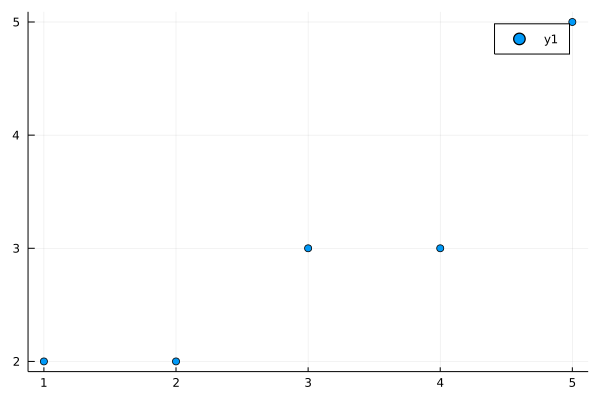

In [29]:
scatter(1:1:5, [2,2,3,3,5])

# Zadania

In [30]:
decode16(x::Float16) = (b=bitstring(x); (b[1], b[2:6], b[7:16]))
decode64(x::Float64) = (b=bitstring(x); (b[1], b[2:12], b[13:64]))

decode64 (generic function with 1 method)

<b> Zadanie 1 </b>  Porównać w języku Julia reprezentację bitową liczby 1/3 dla Float16, Float32, Float64 oraz liczby, 
która jest inicjalizowana jako Float16, a potem rzutowana na Float64.

#### Zadanie 1 Rozwiązanie

In [41]:
println("Float16: ",bitstring(Float16(1/3)))
println(decode16(Float16(1/3)))

println("Float32: ",bitstring(Float32(1/3)))
println(decode(Float32(1/3)))

println("Float64: ",bitstring(Float64(1/3)))
println(decode64(Float64(1/3)))

println("F16->64: ",bitstring(Float64(Float16(1/3))))
println(decode64(Float64(Float16(1/3))))

println()

println("Float16: ", Float16(1/3))
println("Float32: ", Float32(1/3))
println("Float64: ", Float64(1/3))
println("F16->64: ", Float64(Float16(1/3)))

Float16: 0011010101010101
('0', "01101", "0101010101")
Float32: 00111110101010101010101010101011
('0', "01111101", "01010101010101010101011")
Float64: 0011111111010101010101010101010101010101010101010101010101010101
('0', "01111111101", "0101010101010101010101010101010101010101010101010101")
F16->64: 0011111111010101010101000000000000000000000000000000000000000000
('0', "01111111101", "0101010101000000000000000000000000000000000000000000")

Float16: 0.3333
Float32: 0.33333334
Float64: 0.3333333333333333
F16->64: 0.333251953125


Najdokładniejszy oczywiście Float64 potem Float32, Float16, potem konwersja z 16 na 64

<b>Zadanie 2</b> Zbadać, jak zmienia się odległość między kolejnymi liczbami zminnoprzecinkowymi 
reprezentowanymi w komputerze za pomocą języka Julia. 
Narysować wykres używając Plots zależności odległości od wartości liczby dla zakresu  od 1.0 do 1000000.0.

#### Zadanie 2 Rozwiązanie

In [42]:
function dist(x)
    nextfloat(x)-x
end


dist (generic function with 1 method)

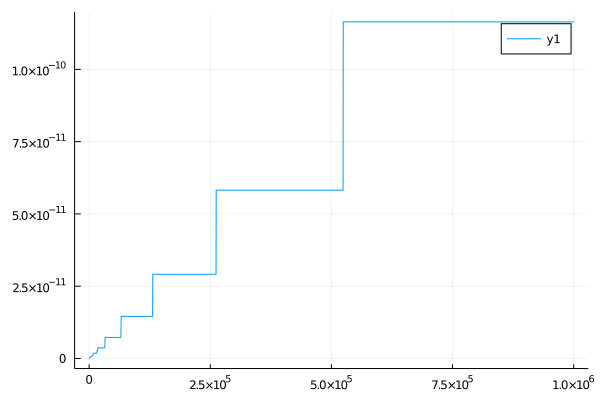

In [43]:
plot(dist,1,1000000)

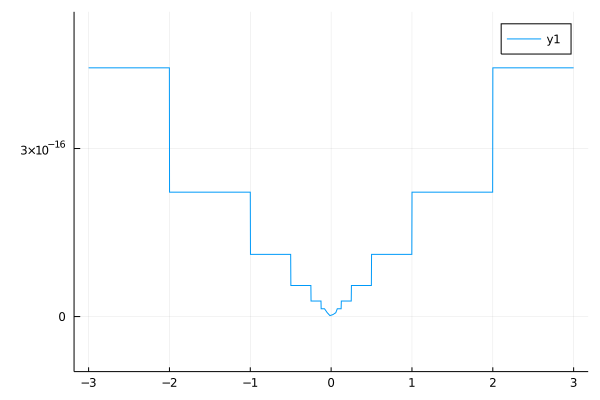

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Piotrek\.julia\packages\PlotUtils\es5pb\src\ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Piotrek\.julia\packages\PlotUtils\es5pb\src\ticks.jl:283


In [44]:
plot(dist,-3,3)

<b>Zadanie 3</b> Jedną z bibliotek numerycznych, jaką będziemy używać na zajęciach jest <a href="http://home.agh.edu.pl/~kzajac/dydakt/mownit/lab1/gsl.html">GSL</a> (język C). Korzystając ze <a href="https://www.gnu.org/software/gsl/doc/html/ieee754.html"> wsparcia dla wyświetlania reprezentacji liczb zmiennoprzecinkowych</a> zobaczyć jak zmienia się cecha i mantysa dla coraz mniejszych liczb. Zaobserwować, kiedy matysa przestaje być znormalizowana i dlaczego?

#### Zadanie 3 Rozwiązanie

Mantysa przestaje być znormalizowana bo nie możemy bardziej zmniejszyć wykładnika (np. najmniejszy wykładnik dla floata to -127).

KOD W C++ (dla floata niemal identyczny)

.#include iostream>

.#include <stdio.h>

.#include <gsl/gsl_ieee_utils.h>


void show_repr(double a) {


	gsl_ieee_double_rep r;
	gsl_ieee_double_to_rep(&a, &r);
	gsl_ieee_printf_double(&a);
	std::cout << ", mantissa: " << r.mantissa;
	std::cout << ", exponent: " << r.exponent;
	std::cout << ", sign: " << r.sign;
	std::cout << ", type: " << r.type;
	if (r.type == 4) {
		std::cout << " Denormal";
	}
}

int main(void)
{

	double a = 1;
	for (int i = 0; i < 1080; i++) {
		show_repr(a);
		std::cout << "\n";
		a = a / 2.0;
	}

	return 0;
}


Float

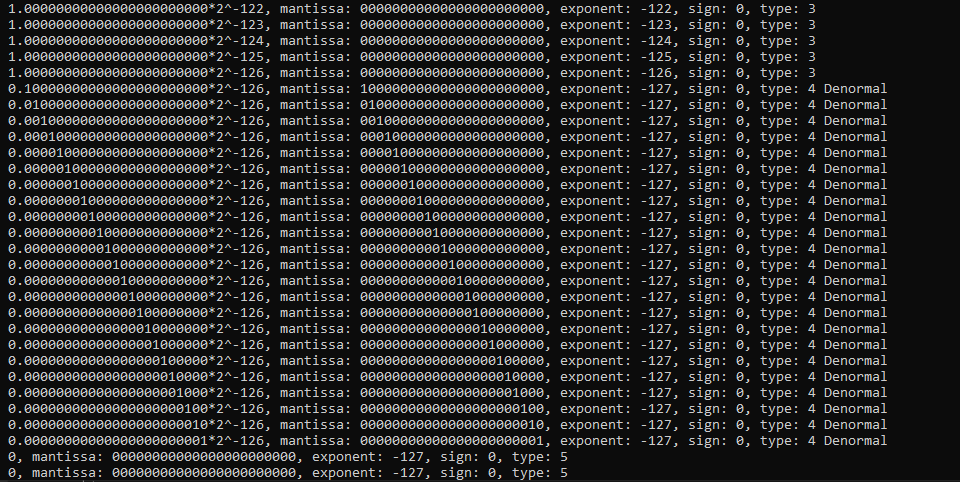

Double

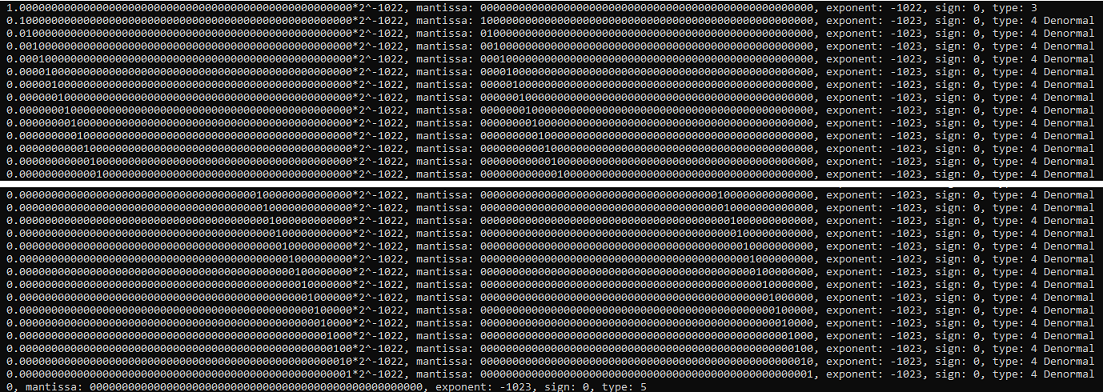

<b>Zadanie 4</b> Na przykładzie wybranego algorytmu niestabilnego numerycznie: 
1. Pokazać, że działa źle.
2. Pokazać które konkretnie działania powodują zwiększenie błędu (np. dzielenie przez małą liczbę, cancellation).
3. Zademonstować wersję stabilną.

Wszystkie punkty przedstawić w postaci notatnika Julii.

#### Zadanie 4 Rozwiązanie

In [7]:
# ALGORYTM 
function f(x)
    (1-(cos(x))^2)/x^2
end

function g(x)
    ((sin(x))^2)/x^2
end

g (generic function with 1 method)

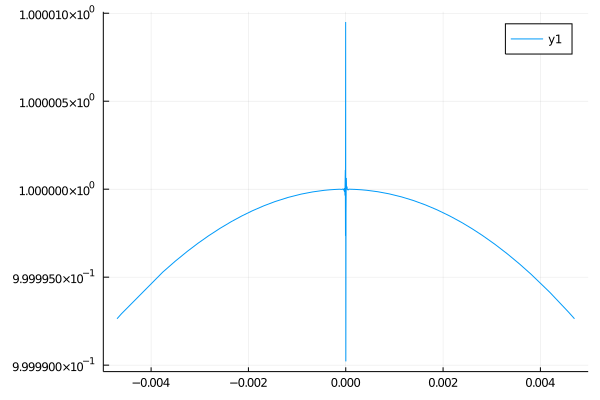

In [8]:
# WERSJA NIESTABLINA
plot(f, -0.0047,0.0047)

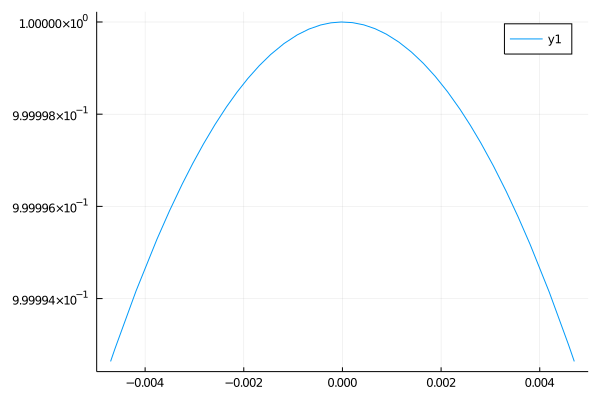

In [9]:
# WERSJA STABILNA
plot(g, -0.0047,0.0047)

WYJAŚNIENIE

Występuje cancellation w funkcji f dla małego x:

bo 1~=cos^2 (x) więc przy odejmowaniu dwóch bliskich sobie liczb wystąpi cancellation

oraz występuje błąd zaokrąglenia cos(x)